In [2]:
# Load Libraries
library(Seurat)
library(SeuratDisk)
library(SingleR)
library(voxhunt)
library(dplyr)
library(data.table)
library(msigdbr)
library(fgsea)
library(ggplot2)
library(SCopeLoomR)
library(SCENIC)
library(AUCell)
library(KernSmooth)
library(plotly)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(patchwork)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls,

In [2]:
# Set Working Directory
setwd("../")

In [7]:
library(gplots)
col2hex('dodgerblue3')

[1] "#1874CD"

# Load Data

In [3]:
data <- readRDS("GBMProject/GBMOrganoid/Checkpoints/1_DataPreprocessing.rds")
data

An object of class Seurat 
25403 features across 5073 samples within 2 assays 
Active assay: RNA (25400 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, umap

In [8]:
library(sceasy)

# convert RNA data to anndata
DefaultAssay(data) <- 'RNA'
data[["RNA"]] <- as(object = data[["RNA"]], Class = "Assay")

# convert RNA data to  anndata
convertFormat(data, from="seurat", to="anndata", main_layer="counts", assay="RNA", drop_single_values=FALSE, outFile='GBMProject/GBMOrganoid/Checkpoints/sc_data.h5ad')

Loading required package: reticulate

Warning message:
“Assay RNA changing from Assay5 to Assay”


AnnData object with n_obs × n_vars = 5073 × 25400
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'pct.mito', 'RNA_snn_res.0.4', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'SingleR.labels', 'celltype', 'celltype2'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    obsm: 'X_pca', 'X_umap'

# Fig 2a - UMAPs

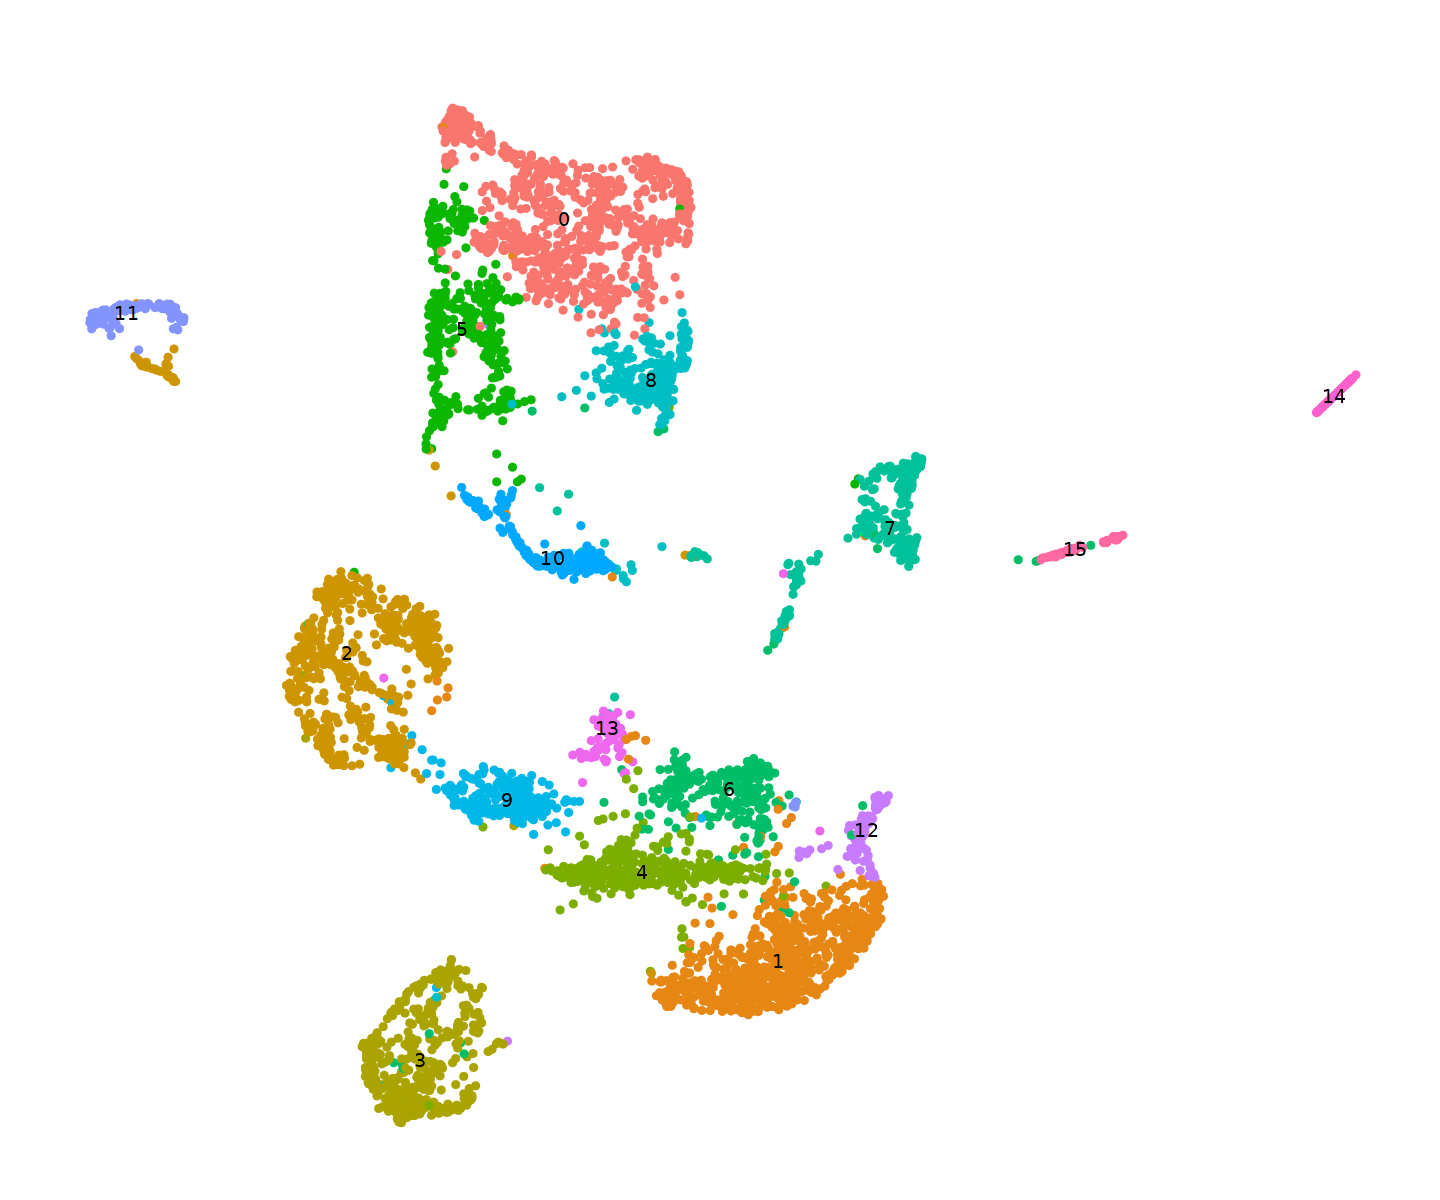

In [4]:
options(repr.plot.width = 12, repr.plot.height = 10)
DimPlot(data, group.by = "seurat_clusters", label = TRUE, 
        pt.size=1.5) + NoAxes() + ggtitle("") + NoLegend()

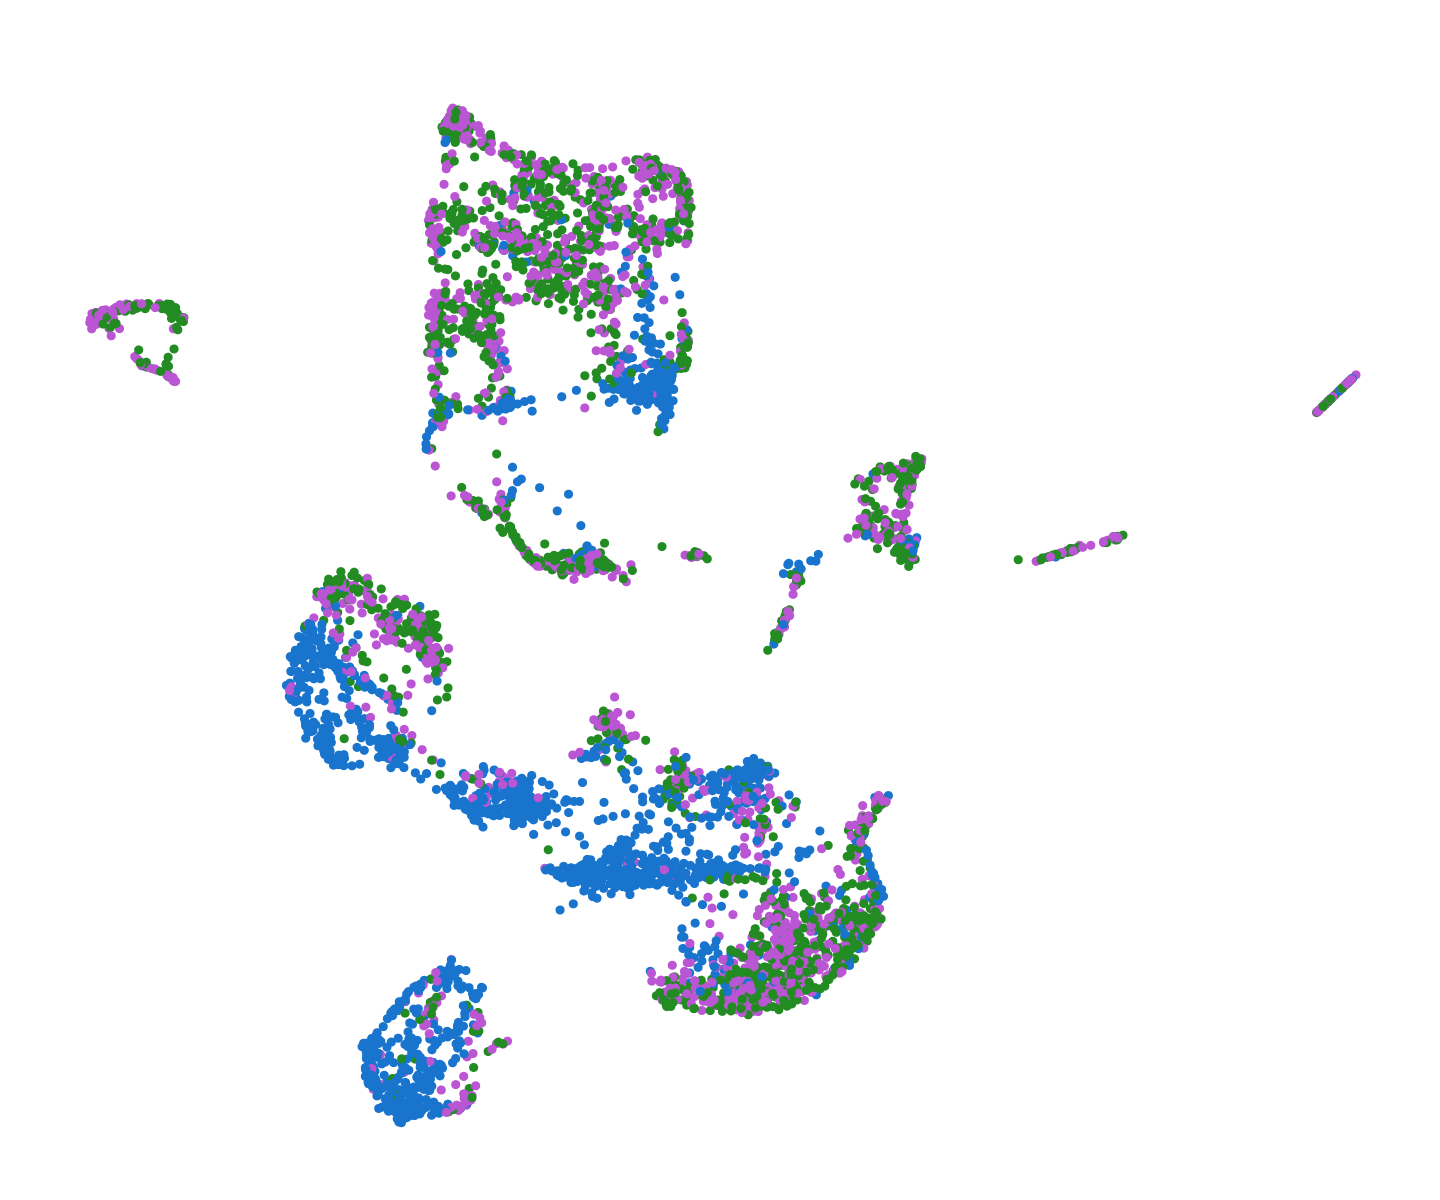

In [5]:
options(repr.plot.width = 12, repr.plot.height = 10)
DimPlot(data, group.by = "HTO_maxID", label = FALSE, 
        cols=c("MES"="forestgreen","PRO"="mediumorchid","WT"="dodgerblue3"), pt.size=1.5) + NoAxes() + ggtitle("") + NoLegend()

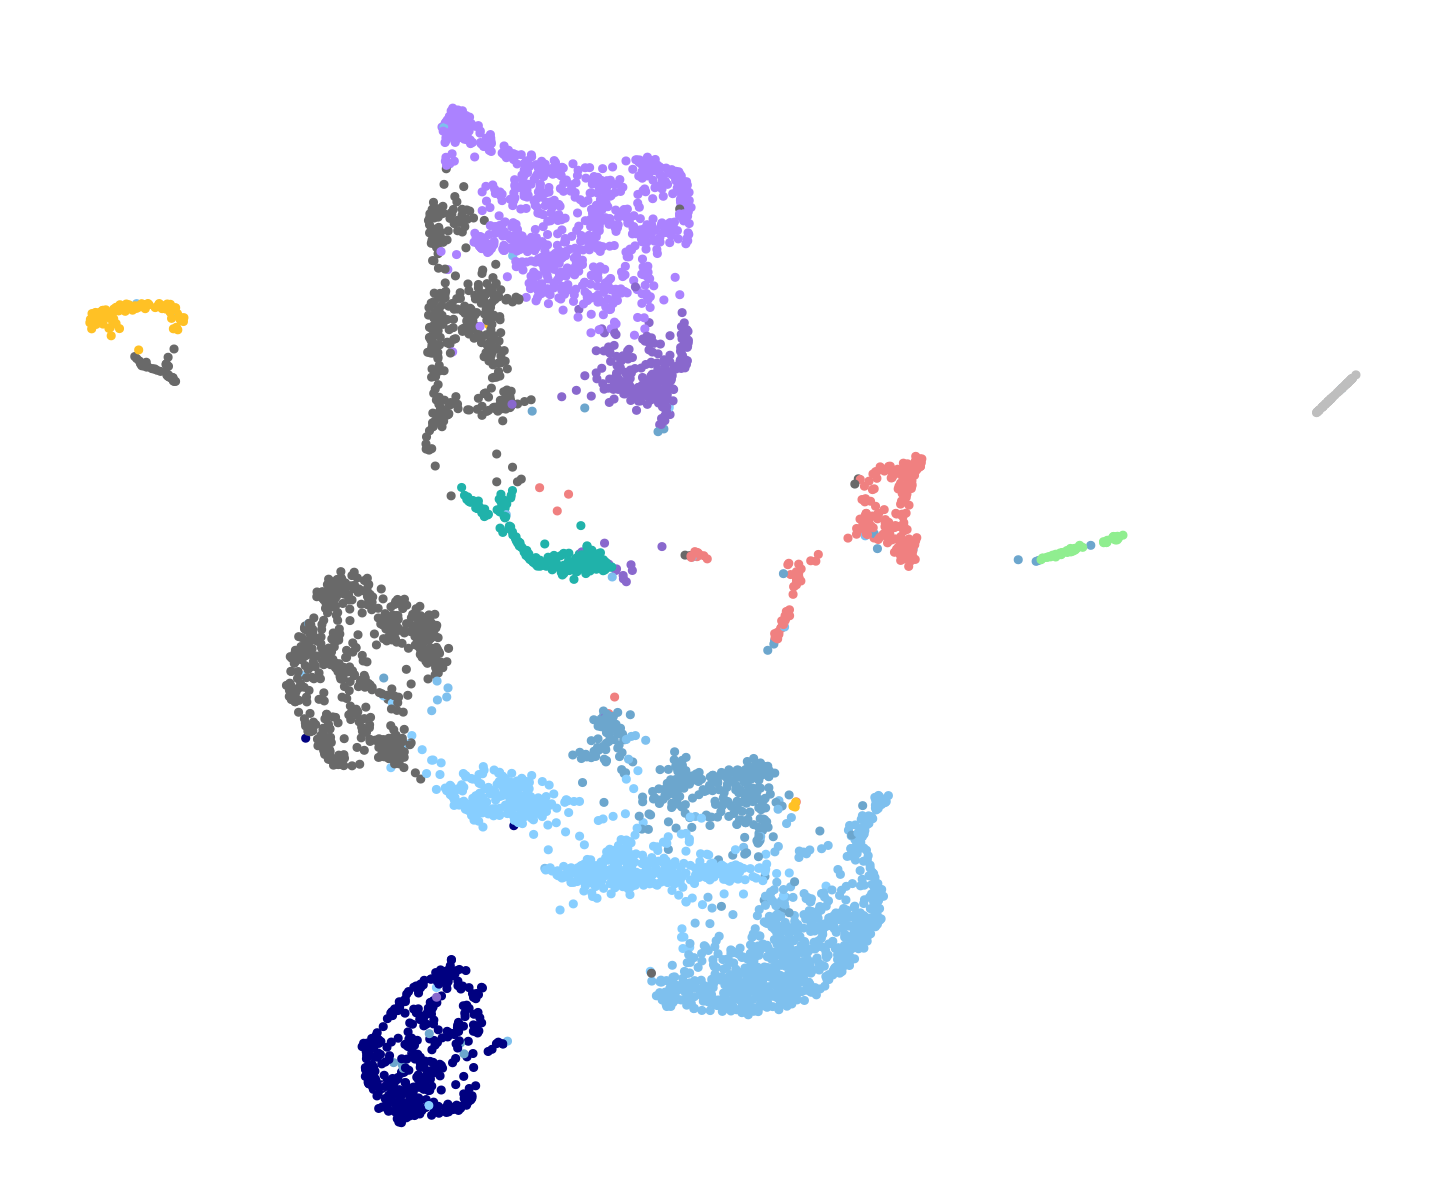

In [7]:
options(repr.plot.width = 12, repr.plot.height = 10)
DimPlot(data, group.by = "seurat_clusters", label = FALSE, 
        cols=c("0"="mediumpurple1","1"="skyblue2","2"="dimgray","3"="navyblue","4"="skyblue1",
              "5"="dimgray","6"="skyblue3","7"="lightcoral","8"="mediumpurple3",
              "9"="skyblue1","10"="lightseagreen","11"="goldenrod1","12"="skyblue2",
              "13"="skyblue3","14"="gray","15"="lightgreen"), pt.size=1.5) + NoAxes() + ggtitle("") + NoLegend()

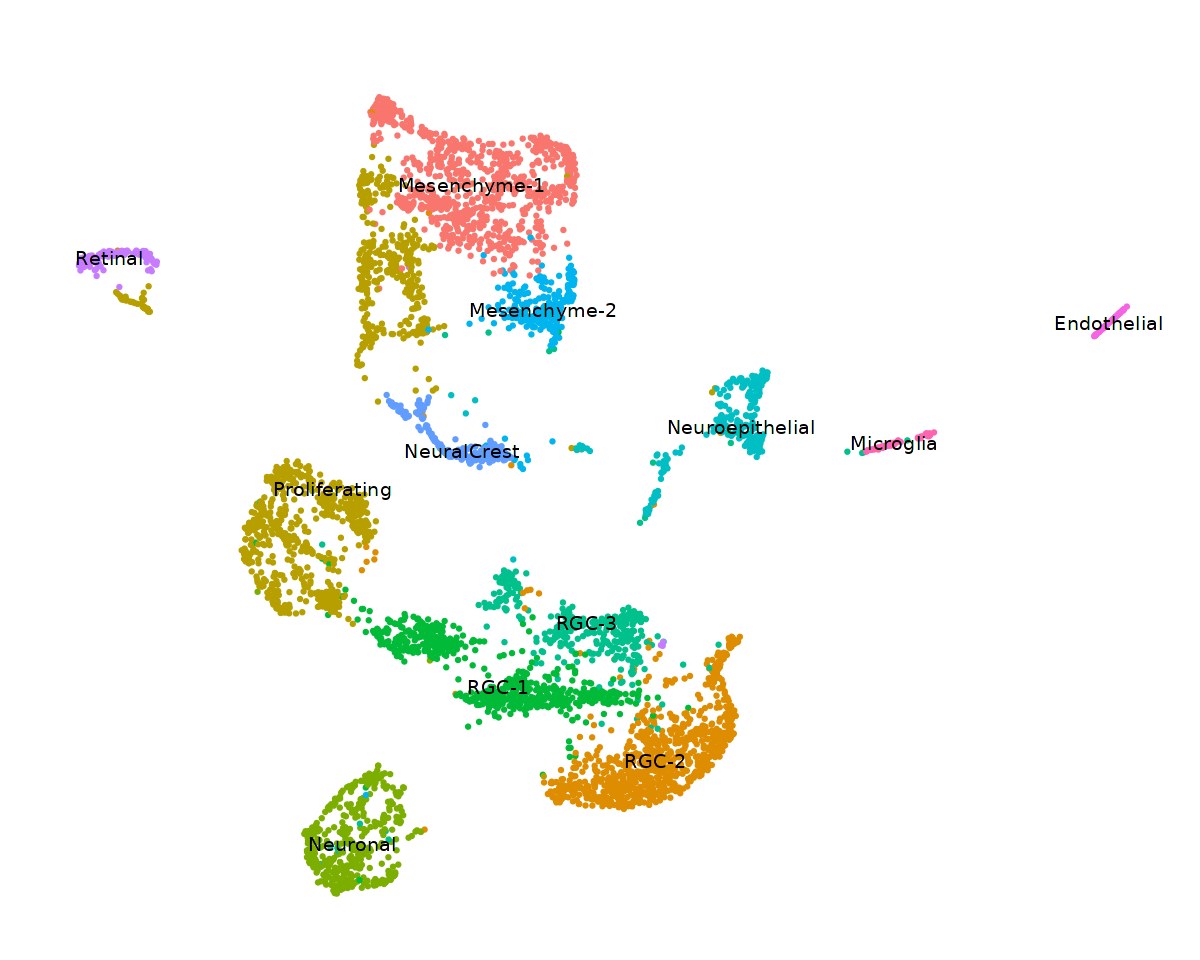

In [9]:
options(repr.plot.width = 10, repr.plot.height = 8)
DimPlot(data, group.by = "celltype2", label = TRUE, 
       pt.size=0.75) + NoAxes() + ggtitle("") + NoLegend()

# Fig 2b - VoxHunt

In [10]:
vox_map <- readRDS("GBMProject/GBMOrganoid/Checkpoints/VoxHunt_voxmap.rds")

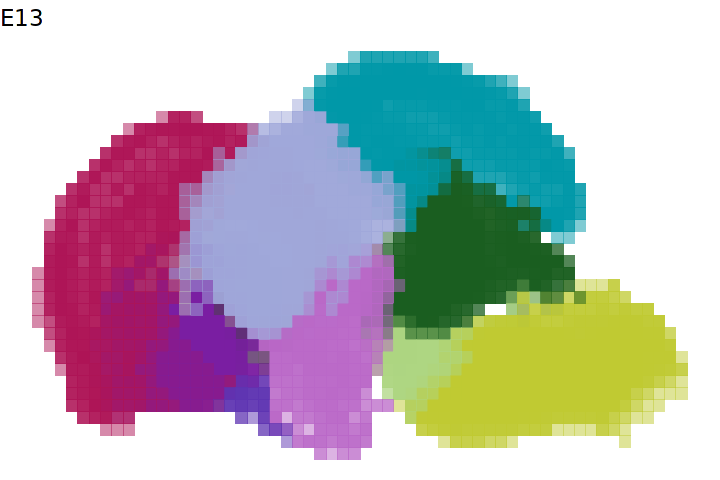

In [11]:
options(repr.plot.width = 6, repr.plot.height = 4)
voxhunt::plot_annotation('E13')

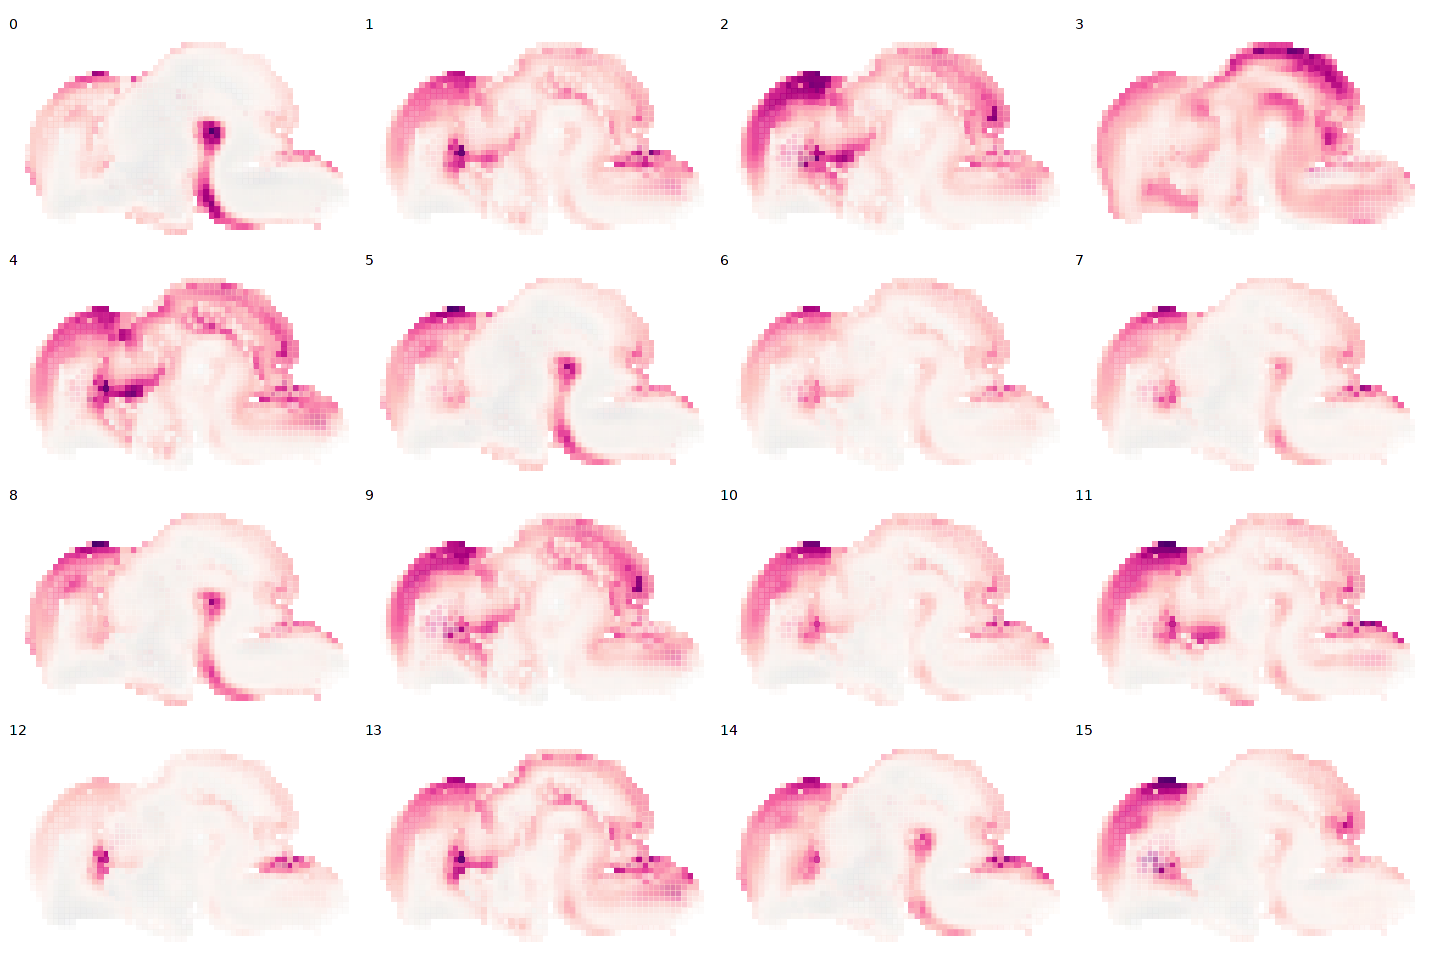

In [15]:
options(repr.plot.width = 12, repr.plot.height = 8)
plot_map(vox_map) + plot_layout(axes = "collect", axis_titles = "collect", guides="collect") &
  theme(legend.position='none')

# Fig 2c - Dotplot

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


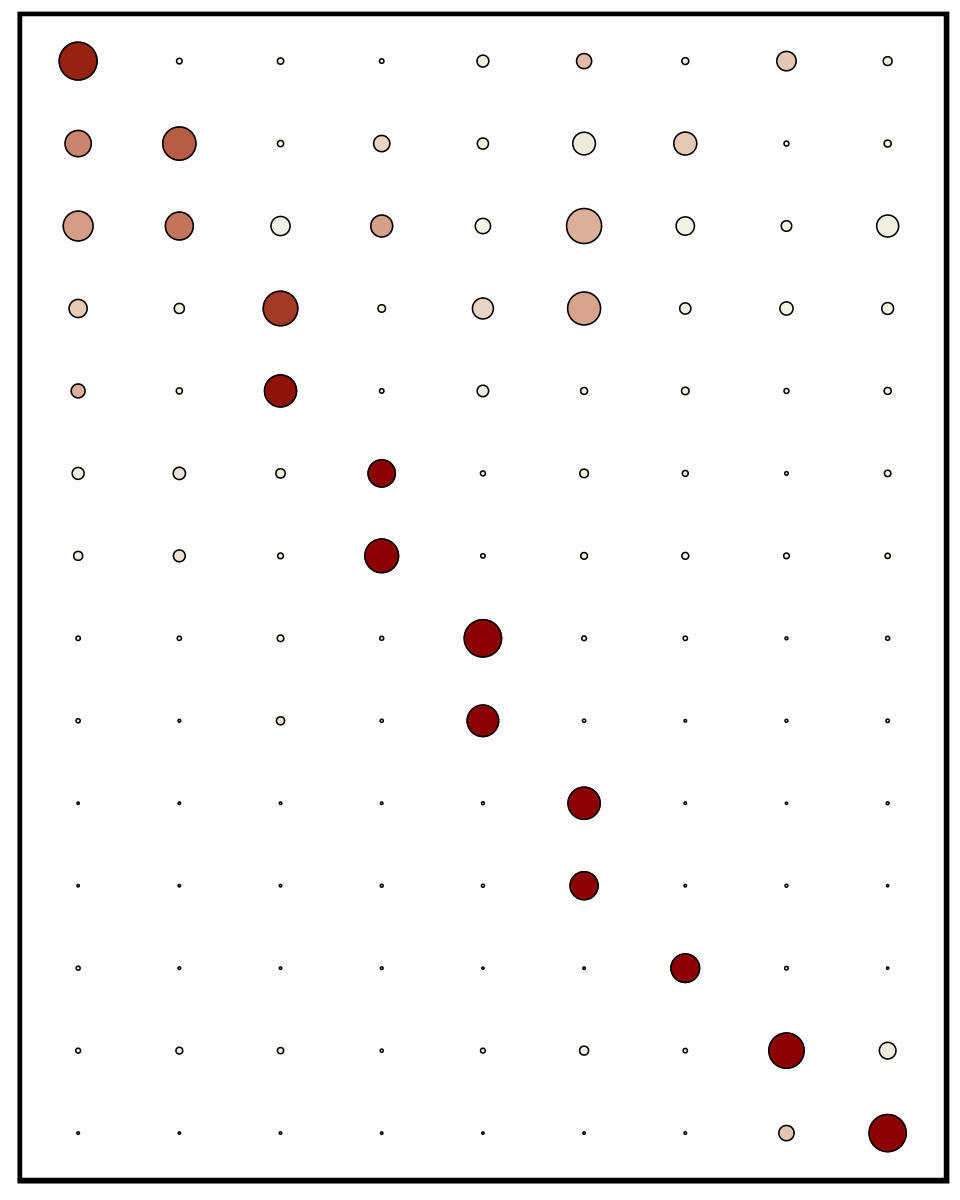

In [21]:
options(repr.plot.width = 8, repr.plot.height = 10)

Idents(data) <- "celltype"
genes = c("PECAM1","AIF1","SIX6","FOXD3","SOX10","CDH1","EPCAM","DCX","GAP43","DCN","COL1A2","NES","SOX2","MKI67")
#microglia markers = C1QC, GPR34
data@active.ident <- factor(data@active.ident, 
                            levels=c("Proliferating","Radial Glia","Mesenchyme","Neuronal","Neuroepithelial","Neural Crest","Retina Progenitor","Microglia","Endothelial"))

DotPlot(data, features = genes, dot.scale = 10) + NoLegend() +
  geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) + coord_flip() + 
  scale_colour_gradient2(low = "ivory", mid = "ivory2", high = "red4") + NoAxes() +
  guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white"))) + 
theme(panel.border=element_rect(colour="black",fill=NA,size=2),panel.margin=unit(0,"cm"),panel.background=element_rect(fill="white")) 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


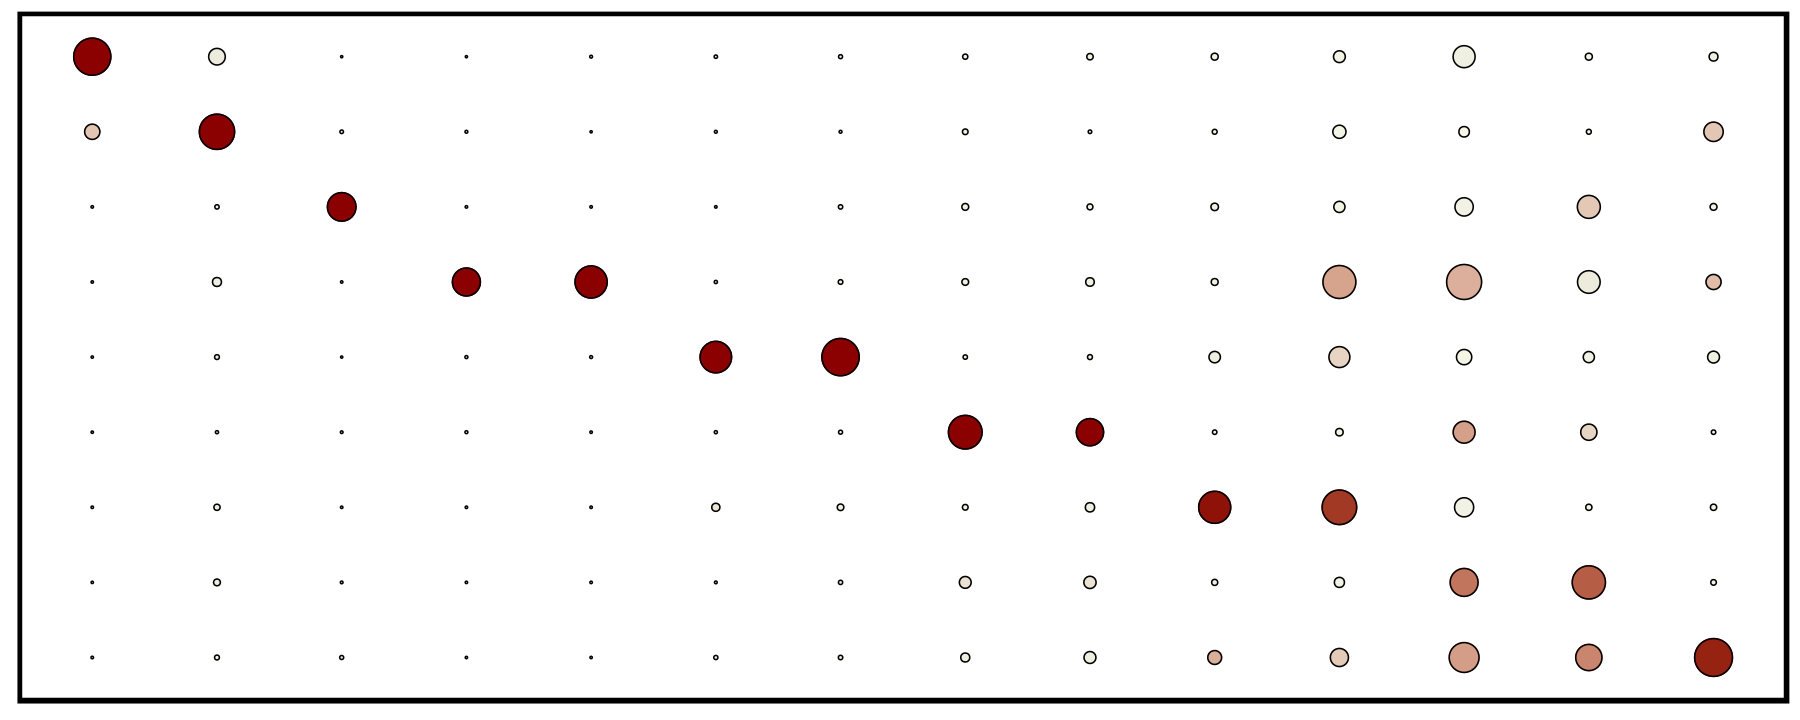

In [6]:
DotPlot(data, features = genes, dot.scale = 10) + NoLegend() +
  geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) + 
  scale_colour_gradient2(low = "ivory", mid = "ivory2", high = "red4") + NoAxes() +
  guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white"))) + 
theme(panel.border=element_rect(colour="black",fill=NA,size=2),panel.margin=unit(0,"cm"),panel.background=element_rect(fill="white")) 

# Fig 2d - Bar Graph

In [31]:
# Calculate cell type proportions
prop.celltype <- data.frame(prop.table(table(data$celltype2,data$HTO_maxID)))

colnames(prop.celltype) <- c("CellType","HTO", "Frac")
prop.celltype$CellType <- as.character(prop.celltype$CellType)

prop.celltype$CellType <- factor(prop.celltype$CellType, levels=c("Proliferating","RGC-1", "RGC-3", "RGC-2",
                                                                 "Mesenchyme-1","Mesenchyme-2","Neuronal",
                                                                 "Neuroepithelial","NeuralCrest",
                                                                  "Retinal", "Microglia","Endothelial"))

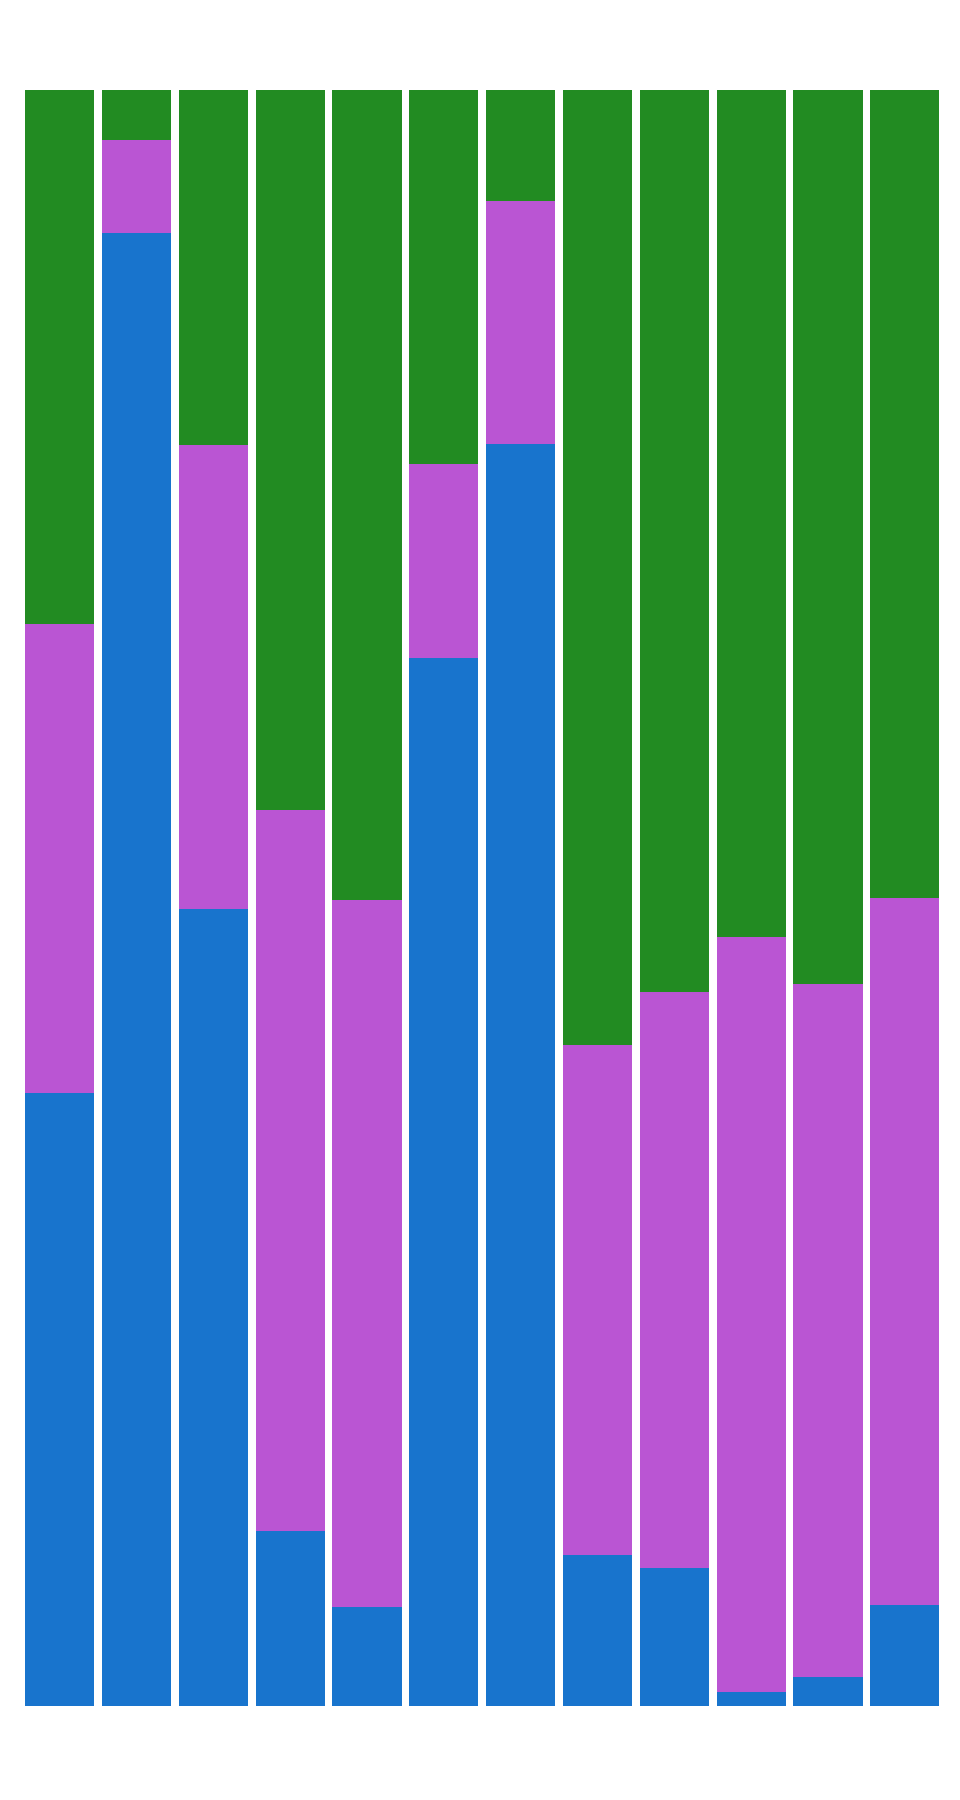

In [33]:
options(repr.plot.width = 8, repr.plot.height = 15)

prop.plot <- ggplot(prop.celltype, aes(fill=factor(HTO), y=Frac, x=CellType)) +
  geom_bar(position="fill", stat="identity", width = .9) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 7)) +
  labs(x = "", y = "Proportion of cells") +
  guides(fill = guide_legend(title="hto"))+ NoAxes() +
  scale_fill_manual(values=c("forestgreen","mediumorchid","dodgerblue3")) + NoLegend()

prop.plot

# Fig 2e - Volcano Plots

In [4]:
markers.WT.PRO <- read.csv('GBMProject/GBMOrganoid/GeneLists/HTOMarkers_Wilcox_WT-PRO_volcano.csv')
markers.WT.MES <- read.csv('GBMProject/GBMOrganoid/GeneLists/HTOMarkers_Wilcox_WT-MES_volcano.csv')

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


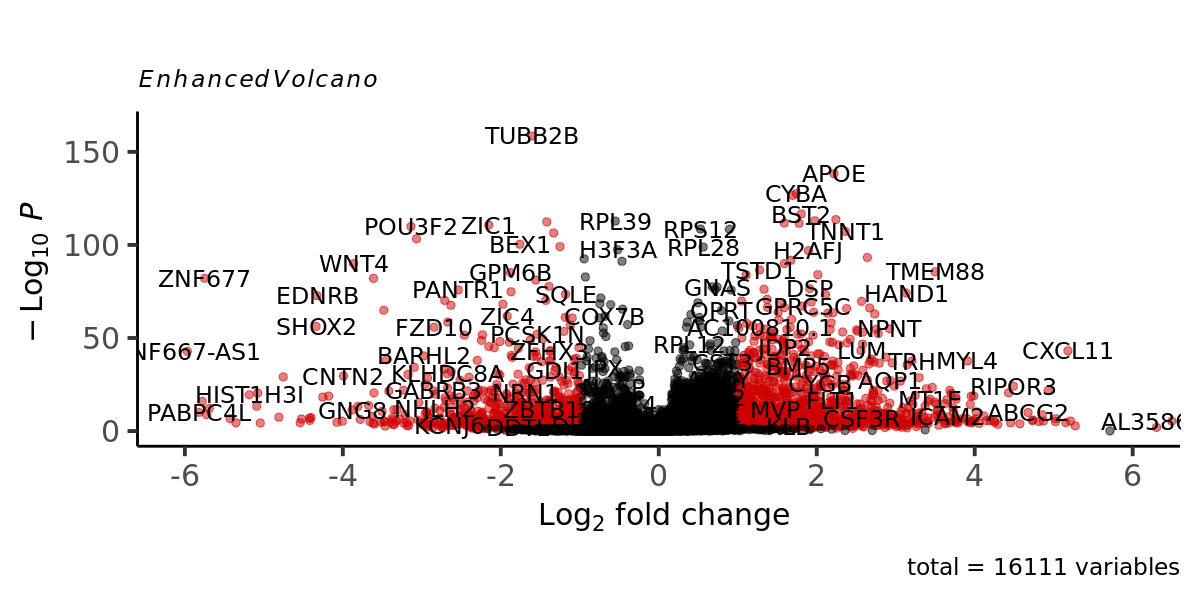

In [5]:
options(repr.plot.width = 10, repr.plot.height = 5)

EnhancedVolcano(markers.WT.PRO, markers.WT.PRO$gene, x ="avg_log2FC", y ="p_val",lab = markers.WT.PRO$gene, title = '',
                FCcutoff=1,pCutoff=.05,cutoffLineType = 'blank',col=c('black', 'black', 'black', 'red3'), pointSize = 2.0,
                gridlines.major = FALSE,gridlines.minor = FALSE)+ NoLegend() + ggplot2::coord_cartesian(xlim=c(-6, 6)) + 
                ggplot2::scale_x_continuous(breaks=seq(-8,8,2))

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


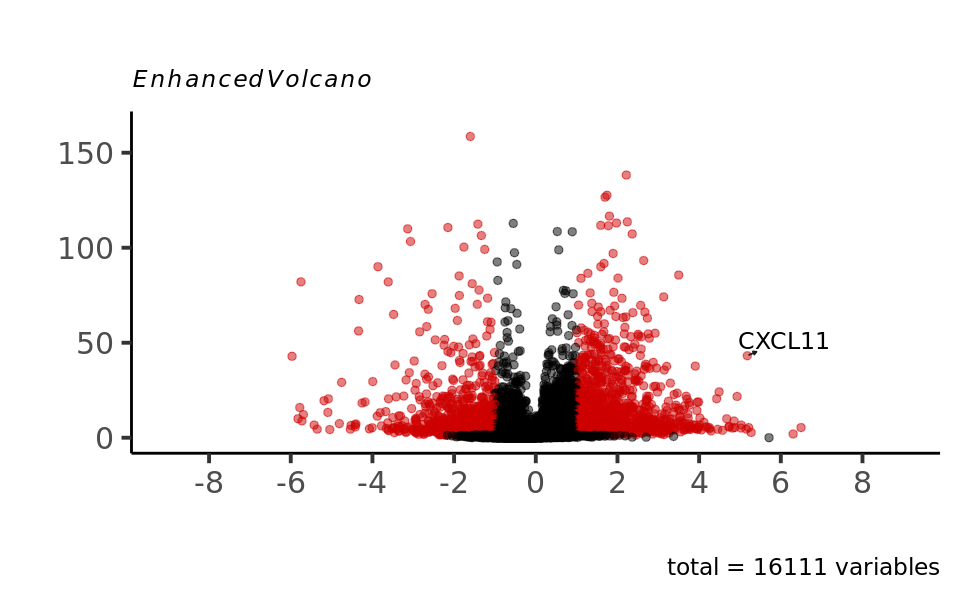

In [27]:
options(repr.plot.width = 8, repr.plot.height = 5)

EnhancedVolcano(markers.WT.PRO, markers.WT.PRO$gene, x ="avg_log2FC", y ="p_val",lab = markers.WT.PRO$gene, title = '', selectLab = c('CXCL11'), drawConnectors = TRUE,
                FCcutoff=1,pCutoff=.05,cutoffLineType = 'blank',col=c('black', 'black', 'black', 'red3'), pointSize = 2.0,
                gridlines.major = FALSE,gridlines.minor = FALSE)+ NoLegend() + ggplot2::coord_cartesian(xlim=c(-9, 9)) + 
                ggplot2::scale_x_continuous(breaks=seq(-8,8,2)) + xlab('') + ylab('')

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


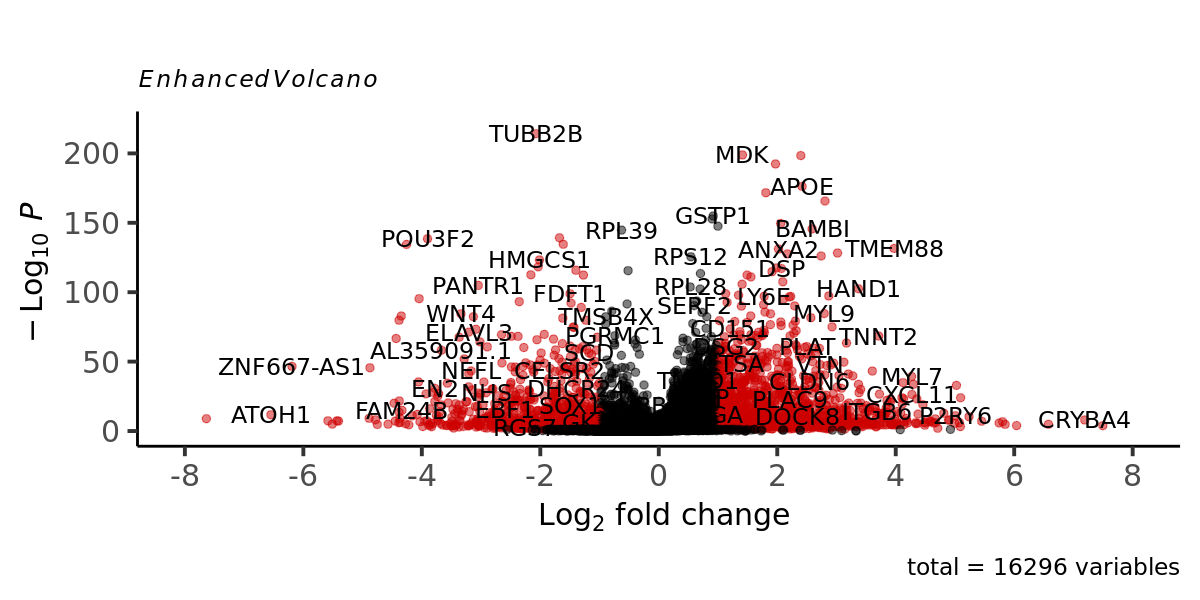

In [7]:
options(repr.plot.width = 10, repr.plot.height = 5)

EnhancedVolcano(markers.WT.MES, markers.WT.MES$gene, x ="avg_log2FC", y ="p_val",lab = markers.WT.MES$gene, title = '',
                FCcutoff=1,pCutoff=.05,cutoffLineType = 'blank',col=c('black', 'black', 'black', 'red3'), pointSize = 2.0,
                gridlines.major = FALSE,gridlines.minor = FALSE)+ NoLegend() + ggplot2::coord_cartesian(xlim=c(-8, 8)) + 
                ggplot2::scale_x_continuous(breaks=seq(-8,8,2))

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


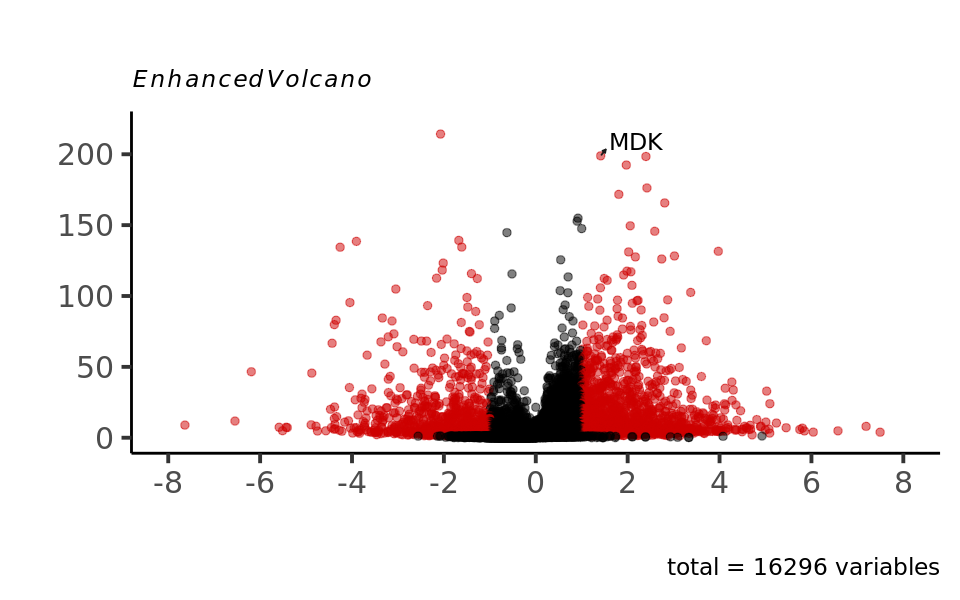

In [25]:
options(repr.plot.width = 8, repr.plot.height = 5)

EnhancedVolcano(markers.WT.MES, markers.WT.MES$gene, x ="avg_log2FC", y ="p_val",lab = markers.WT.MES$gene, title = '', selectLab = c('MDK'), drawConnectors = TRUE,
                FCcutoff=1,pCutoff=.05,cutoffLineType = 'blank',col=c('black', 'black', 'black', 'red3'), pointSize = 2.0,
                gridlines.major = FALSE,gridlines.minor = FALSE)+ NoLegend() + ggplot2::coord_cartesian(xlim=c(-8, 8)) + 
                ggplot2::scale_x_continuous(breaks=seq(-8,8,2))+ xlab('') + ylab('')

# Fig 2f - GSEA bar plots

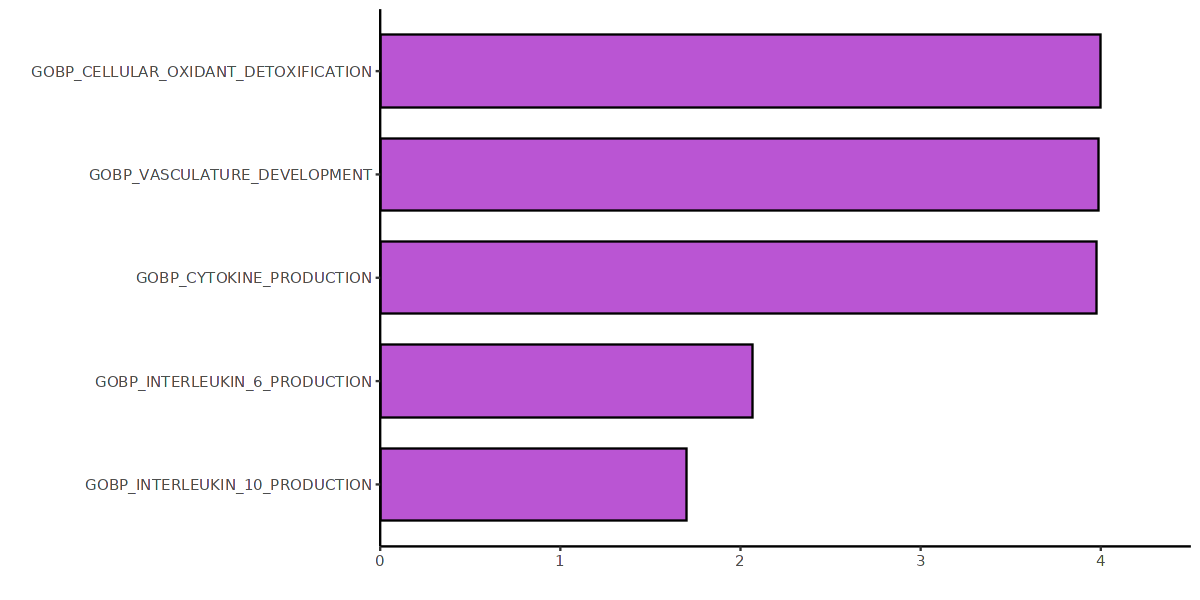

In [9]:
# PROvsWT Up
PRO.up <- read.csv('GBMProject/GBMOrganoid/GSEA/PROup.csv')

options(repr.plot.width = 10, repr.plot.height = 5)
p<-ggplot(data=PRO.up, aes(x=log10_pval, y= reorder(Pathway, log10_pval))) + xlab('') + ylab('') +
  geom_bar(stat="identity", fill="mediumorchid", color="black", width=0.7, position=position_dodge()) + theme_classic() + scale_x_continuous(expand = c(0,0), limits=c(0,4.5))
p

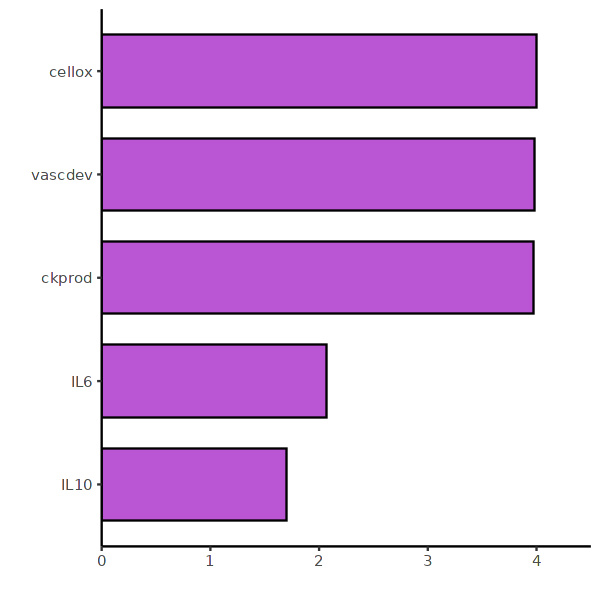

In [17]:
options(repr.plot.width = 5, repr.plot.height = 5)
p<-ggplot(data=PRO.up, aes(x=log10_pval, y= reorder(Pathway, log10_pval))) + xlab('') + ylab('') +
  geom_bar(stat="identity", fill="mediumorchid", color="black", width=0.7, position=position_dodge()) + theme_classic() + scale_x_continuous(expand = c(0,0), limits=c(0,4.5)) +
  scale_y_discrete(labels = c("IL10","IL6","ckprod","vascdev","cellox"))

p

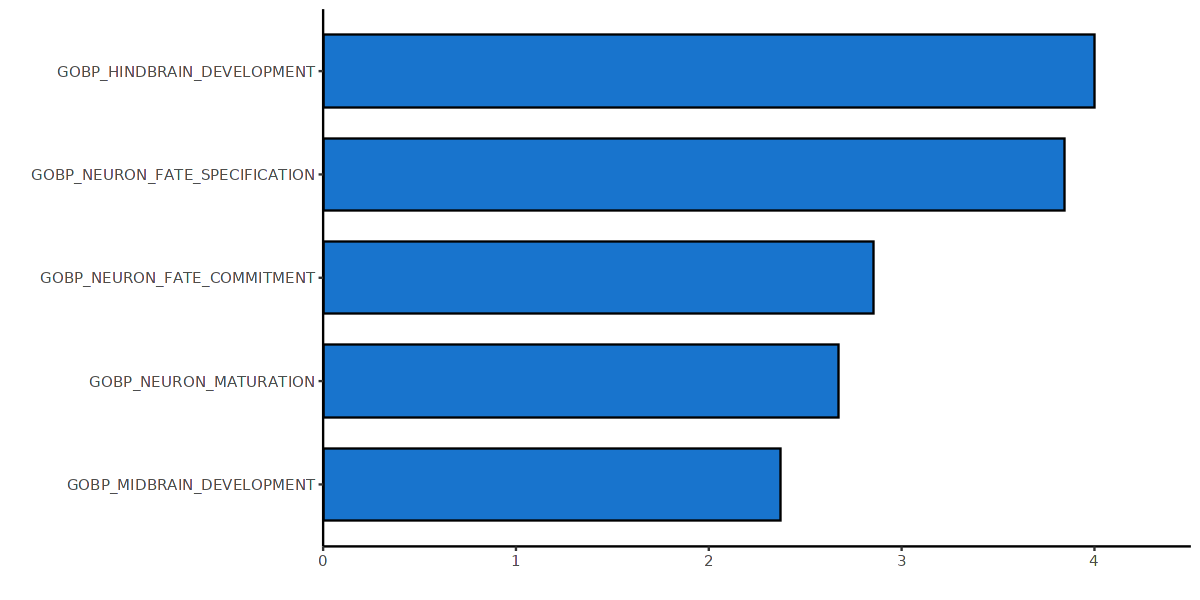

In [11]:
# PROvsWT down
PRO.down <- read.csv('GBMProject/GBMOrganoid/GSEA/PROdown.csv')

options(repr.plot.width = 10, repr.plot.height = 5)
p<-ggplot(data=PRO.down, aes(x=log10_pval, y= reorder(Pathway, log10_pval))) + xlab('') + ylab('') +
  geom_bar(stat="identity", fill="dodgerblue3", color="black", width=0.7, position=position_dodge()) + theme_classic() + scale_x_continuous(expand = c(0,0), limits=c(0,4.5))
p

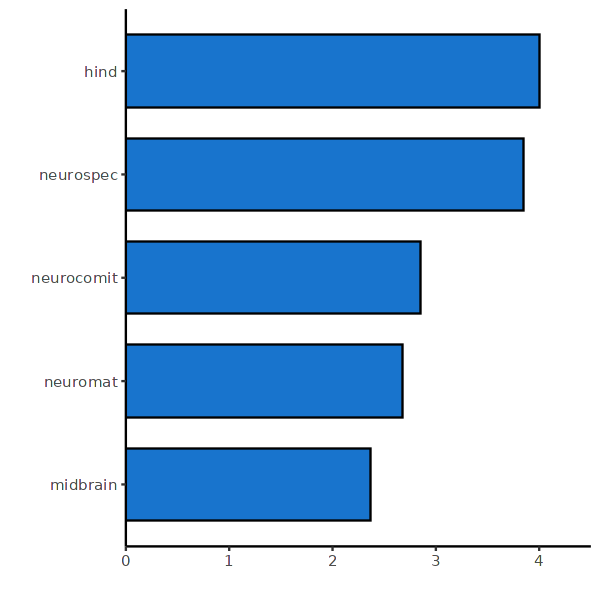

In [18]:
options(repr.plot.width = 5, repr.plot.height = 5)
p<-ggplot(data=PRO.down, aes(x=log10_pval, y= reorder(Pathway, log10_pval))) + xlab('') + ylab('') +
  geom_bar(stat="identity", fill="dodgerblue3", color="black", width=0.7, position=position_dodge()) + theme_classic() + scale_x_continuous(expand = c(0,0), limits=c(0,4.5)) +
  scale_y_discrete(labels = c("midbrain","neuromat","neurocomit","neurospec","hind" ))

p

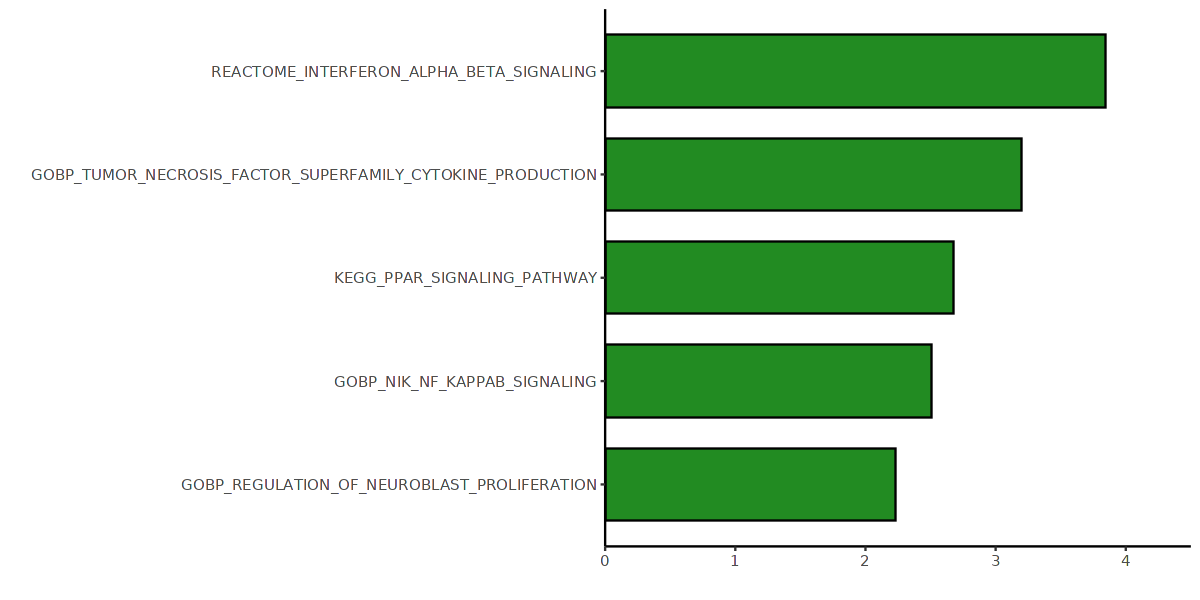

In [13]:
# MESvsWT up
MES.up <- read.csv('GBMProject/GBMOrganoid/GSEA/MESup.csv')

options(repr.plot.width = 10, repr.plot.height = 5)
p<-ggplot(data=MES.up, aes(x=log10_pval, y= reorder(Pathway, log10_pval))) + xlab('') + ylab('') +
  geom_bar(stat="identity", fill="forestgreen", color="black", width=0.7, position=position_dodge()) + theme_classic() + scale_x_continuous(expand = c(0,0), limits=c(0,4.5))
p

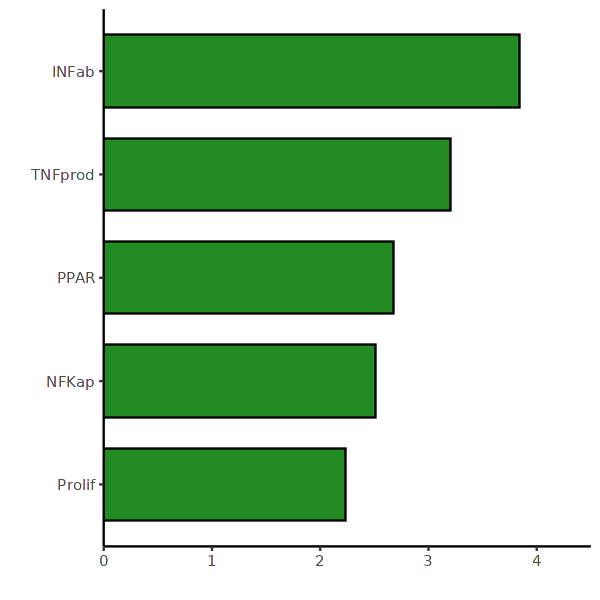

In [19]:
options(repr.plot.width = 5, repr.plot.height = 5)
p<-ggplot(data=MES.up, aes(x=log10_pval, y= reorder(Pathway, log10_pval))) + xlab('') + ylab('') +
  geom_bar(stat="identity", fill="forestgreen", color="black", width=0.7, position=position_dodge()) + theme_classic() + scale_x_continuous(expand = c(0,0), limits=c(0,4.5)) +
  scale_y_discrete(labels = c("Prolif", "NFKap", "PPAR", "TNFprod","INFab"))

p

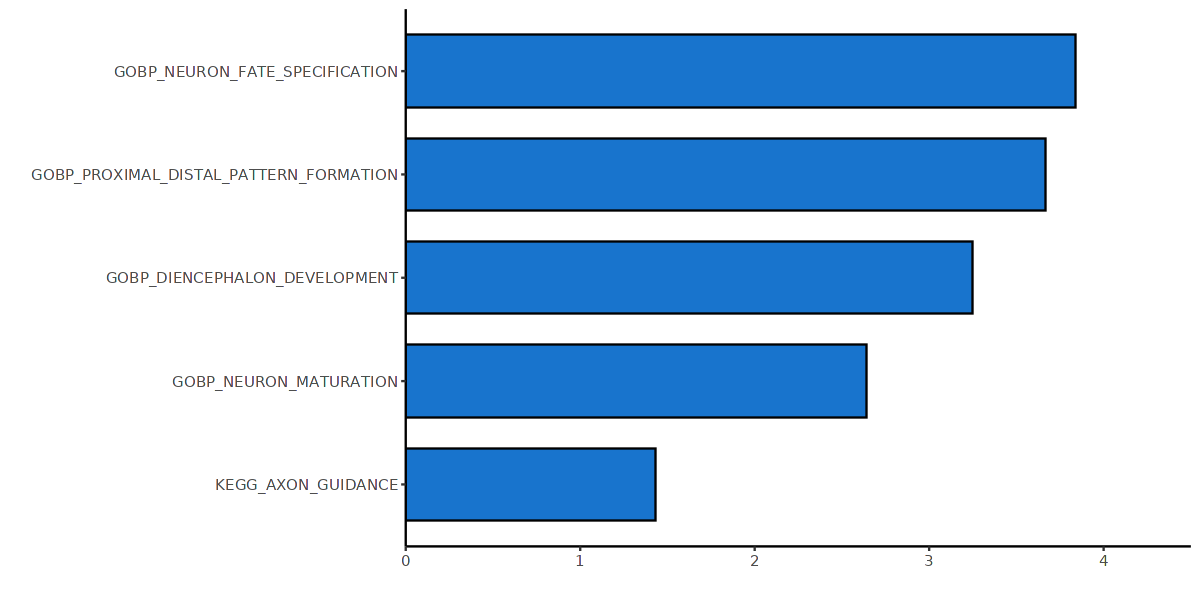

In [15]:
# MESvsWT down
MES.down <- read.csv('GBMProject/GBMOrganoid/GSEA/MESdown.csv')

options(repr.plot.width = 10, repr.plot.height = 5)
p<-ggplot(data=MES.down, aes(x=log10_pval, y= reorder(Pathway, log10_pval))) + xlab('') + ylab('') +
  geom_bar(stat="identity", fill="dodgerblue3", color="black", width=0.7, position=position_dodge()) + theme_classic() + scale_x_continuous(expand = c(0,0), limits=c(0,4.5))
p

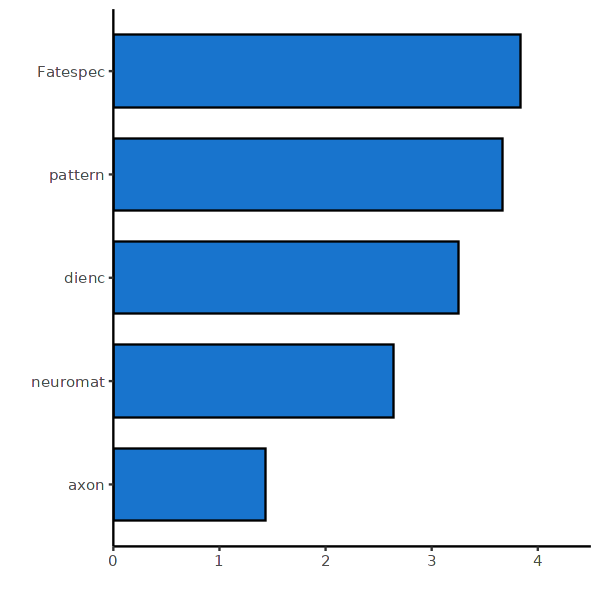

In [20]:
options(repr.plot.width = 5, repr.plot.height = 5)
p<-ggplot(data=MES.down, aes(x=log10_pval, y= reorder(Pathway, log10_pval))) + xlab('') + ylab('') +
  geom_bar(stat="identity", fill="dodgerblue3", color="black", width=0.7, position=position_dodge()) + theme_classic() + scale_x_continuous(expand = c(0,0), limits=c(0,4.5)) +
  scale_y_discrete(labels = c("axon", "neuromat", "dienc", "pattern", "Fatespec"))

p

# Fig 2g - SCENIC GRN

In [ ]:
data <- readRDS("GBMProject/GBMOrganoid/Checkpoints/2_iGRNs.rds")
loom <- open_loom("GBMProject/GBMOrganoid/SCENIC/output_organoid.loom", mode = "r+")

# Read information from loom file:
exprMat <- get_dgem(loom)
exprMat_log <- log2(exprMat+1) # Better if it is logged/normalized
regulons_incidMat <- get_regulons(loom, column.attr.name='Regulons')
regulons <- regulonsToGeneLists(regulons_incidMat)
regulonAUC <- get_regulons_AUC(loom, column.attr.name='RegulonsAUC')
regulonAucThresholds <- get_regulon_thresholds(loom)
embeddings <- get_embeddings(loom)
genotype <- get_cell_annotation(loom,annotations.columns = "genotype")
celltype <- get_cell_annotation(loom,annotations.columns = "maincelltype")
celltype2 <- get_cell_annotation(loom,annotations.columns = "subcelltype")
cluster <- get_cell_annotation(loom,annotations.columns = "cluster")

close_loom(loom)

In [ ]:
selectedResolution <- "genotype" # select resolution

# Split the cells by cluster:
cellsPerGenotype <- split(rownames(genotype), genotype[,selectedResolution]) 
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]

# Calculate average expression:
regulonActivity_byGenotype <- sapply(cellsPerGenotype, function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
write.csv(regulonActivity_byGenotype, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonActivity_avg.csv")  
                                     
# Scale expression:
regulonActivity_byGenotype_Scaled <- t(scale(t(regulonActivity_byGenotype), center = T, scale=T))
write.csv(regulonActivity_byGenotype_Scaled, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonActivity_scaled.csv")   

In [ ]:
# plot:
options(repr.plot.width=10, repr.plot.height=25) # To set the figure size in Jupyter

hm <- draw(ComplexHeatmap::Heatmap(regulonActivity_byGenotype_Scaled, name="Regulon activity",
                       row_names_gp=grid::gpar(fontsize=6))) # row font size

regulonOrder <- rownames(regulonActivity_byGenotype_Scaled)[row_order(hm)] # to save the clustered regulons for later
write.csv(regulonOrder, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonOrder.csv")  

# Fig 2e - GESECA UMAPs

## Fix GESECA plotting functions for Seurat v5

In [8]:
plotCoregProfileReduction <- function(pathway, object, title=NULL,
                                             assay=DefaultAssay(object),
                                             reduction=NULL,
                                             colors=c("darkblue", "lightgrey", "darkred"),
                                             guide="colourbar",
                                             ...) {
    stopifnot(requireNamespace("Seurat"))

    if (is.list(pathway)) {
        if (is.null(title)) {
            titles <- names(pathway)
        } else {
            if (length(title) != length(pathway)) {
                stop("Length of the specified titles does not match count of pathways")
            }
            titles <- title
        }
        ps <- lapply(seq_along(pathway), function(i)
            plotCoregProfileReduction(pathway[[i]],
                                           object=object,
                                           title=titles[i],
                                           assay=assay,
                                           reduction=reduction,
                                           colors=colors,
                                           guide=guide,
                                           ...))
        names(ps) <- names(pathway)
        return(ps)
    }

    obj2 <- addScores(list(pathway=pathway), object, assay=assay,
                            scale=TRUE)

    p <- Seurat::FeaturePlot(obj2, features = "pathway",
                                    combine = FALSE, reduction=reduction, ...)[[1]]
    p <- p + coord_fixed()
    p$scales$scales[p$scales$find("color")] <- NULL

    # suppress message of replacing existing color palette
    suppressMessages(p2 <- p +
        scale_color_gradientn(limits=c(-3, 3), breaks=c(-3, 0, 3),
                             colors=colors,
                             oob=scales::squish,
                             guide=guide,
                             name = "z-score"
        ))

    if (!is.null(title)) {
        p2 <- p2 + ggtitle(title)
    }
    p2
}
                     
addScores <- function(pathways,
                            object,
                            assay=DefaultAssay(object),
                            prefix="",
                            scale=FALSE) {
    x <- GetAssay(object, assay = "RNA")
    E <- x$scale.data

    res <- object


    for (i in seq_along(pathways)) {
        pathway <- pathways[[i]]
        pathway <- intersect(unique(pathway), rownames(E))

        score <- colSums(E[pathway, , drop=FALSE])/sqrt(length(pathway))
        score <- scale(score, center=TRUE, scale=scale)
        res@meta.data[[paste0(prefix, names(pathways)[i])]] <- score
    }


    return(res)
}

## Load GESECA Results

In [9]:
# Run GESECA
set.seed(123)
gesecaRes.h <- readRDS("GBMProject/GBMOrganoid/Checkpoints/GSEA/geseca_h.rds")

gesecaRes.c2 <- readRDS("GBMProject/GBMOrganoid/Checkpoints/GSEA/geseca_c2.rds")

gesecaRes.c5 <- readRDS("GBMProject/GBMOrganoid/Checkpoints/GSEA/geseca_c5.rds")

gesecaRes.c6 <- readRDS("GBMProject/GBMOrganoid/Checkpoints/GSEA/geseca_c6.rds")

gesecaRes.c8 <- readRDS("GBMProject/GBMOrganoid/Checkpoints/GSEA/geseca_c8.rds")

In [11]:
pathways.h <- msigdbr(species = "human", category = "H") #c("H-hallmark gene sets","C5","C6","C8"))
pathways.h <- split(x = pathways.h$gene_symbol, f = pathways.h$gs_name)

pathways.c2 <- msigdbr(species = "human", category = "C2") #c("H","C2-curated gene sets,"C5","C6","C8"))
pathways.c2 <- split(x = pathways.c2$gene_symbol, f = pathways.c2$gs_name)

pathways.c5 <- msigdbr(species = "human", category = "C5") #c("H","C5-ontology gene sets","C6","C8"))
pathways.c5 <- split(x = pathways.c5$gene_symbol, f = pathways.c5$gs_name)

pathways.c6 <- msigdbr(species = "human", category = "C6") #c("H","C5","C6-oncogenic gene sets","C8"))
pathways.c6 <- split(x = pathways.c6$gene_symbol, f = pathways.c6$gs_name)

pathways.c8 <- msigdbr(species = "human", category = "C8") #c("H","C5","C6","C8-cell type gene sets"))
pathways.c8 <- split(x = pathways.c8$gene_symbol, f = pathways.c8$gs_name)

## Plots

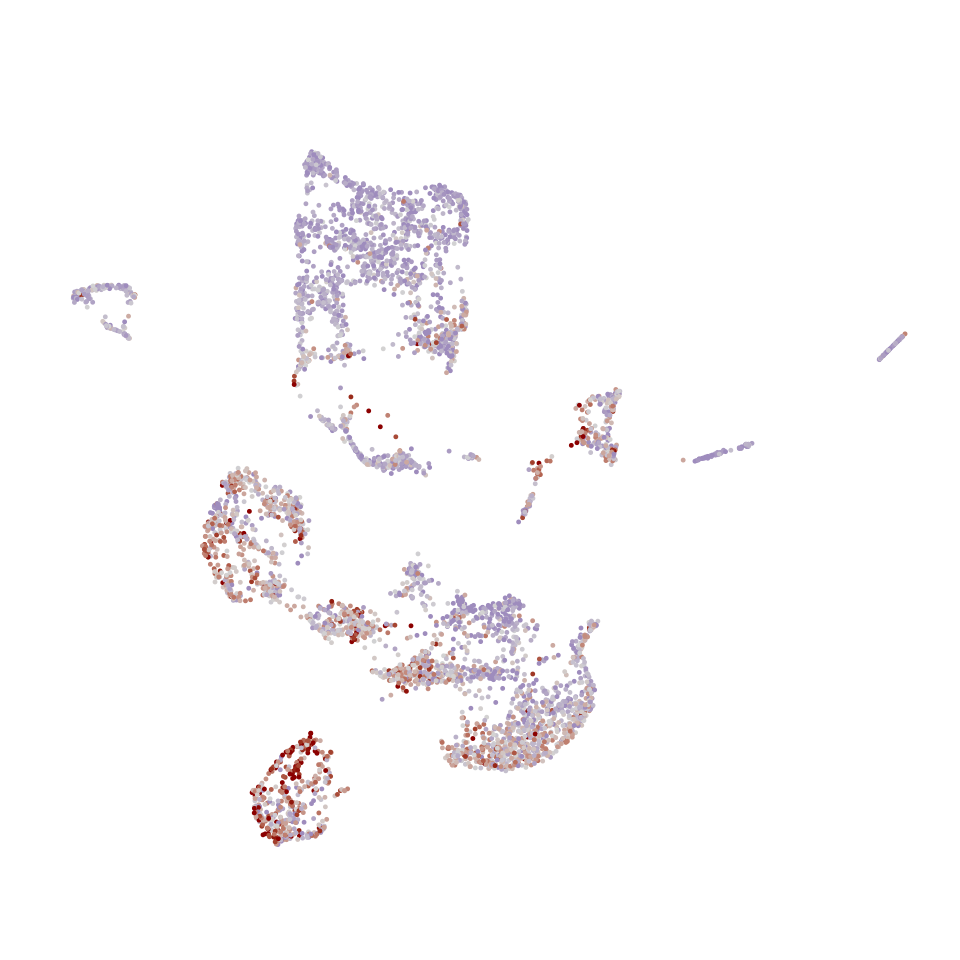

In [23]:
options(repr.plot.width = 8, repr.plot.height = 8)
plotCoregProfileReduction(pathways.c5$GOBP_NEURON_FATE_SPECIFICATION, 
                               data,
                               title='',
                               reduction="umap") + NoAxes() + NoLegend()

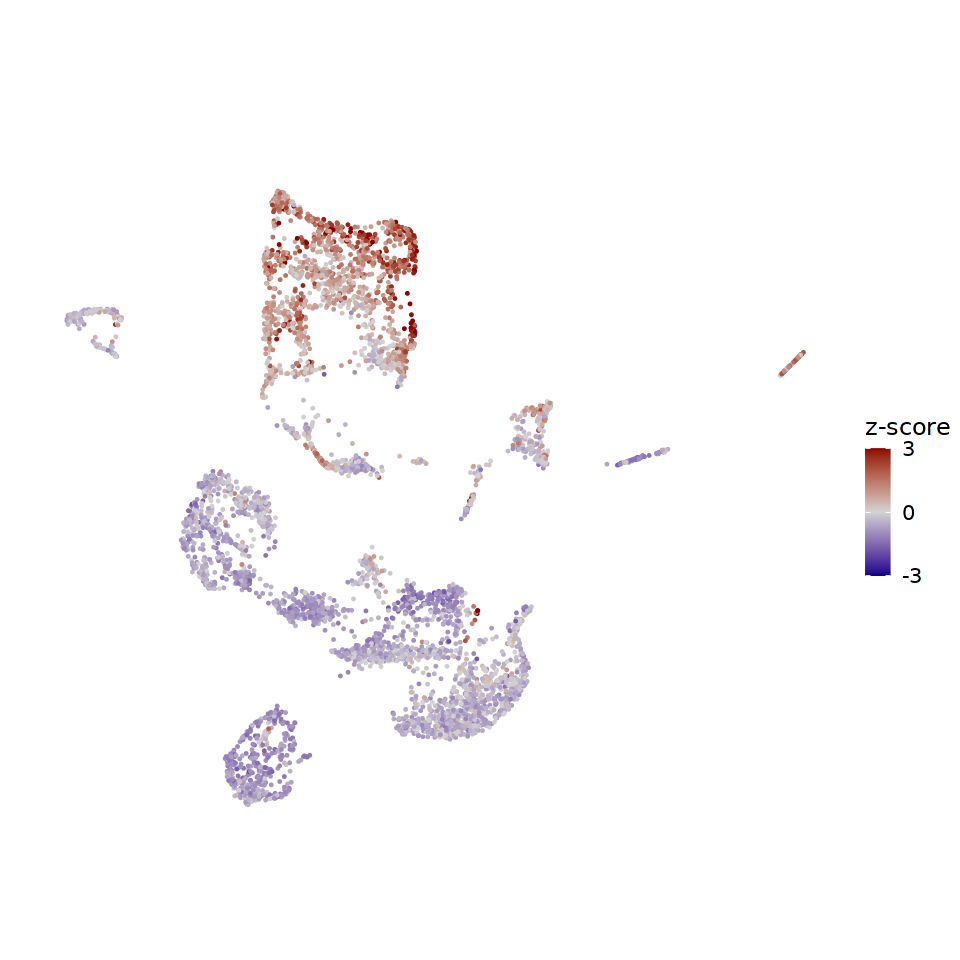

In [24]:
options(repr.plot.width = 8, repr.plot.height = 8)
plotCoregProfileReduction(pathways.h$HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION, 
                               data,
                               title='',
                               reduction="umap") + NoAxes() 

# Fig 2f - SCENIC GRNs

In [3]:
#Load Data
data <- readRDS("GBMProject/GBMOrganoid/Checkpoints/2_iGRNs.rds")
loom <- open_loom("GBMProject/GBMOrganoid/SCENIC/output_organoid.loom", mode = "r+")

# Read information from loom file:
exprMat <- get_dgem(loom)
exprMat_log <- log2(exprMat+1) # Better if it is logged/normalized
regulons_incidMat <- get_regulons(loom, column.attr.name='Regulons')
regulons <- regulonsToGeneLists(regulons_incidMat)
regulonAUC <- get_regulons_AUC(loom, column.attr.name='RegulonsAUC')
regulonAucThresholds <- get_regulon_thresholds(loom)
embeddings <- get_embeddings(loom)
genotype <- get_cell_annotation(loom,annotations.columns = "genotype")
celltype <- get_cell_annotation(loom,annotations.columns = "maincelltype")
celltype2 <- get_cell_annotation(loom,annotations.columns = "subcelltype")
cluster <- get_cell_annotation(loom,annotations.columns = "cluster")

close_loom(loom)

[1] 411

[1] "ALX1(+)"   "ARID3A(+)" "ARNT(+)"   "ARX(+)"    "ATF3(+)"   "ATF4(+)"

AUC for 411 regulons (rows) and 5073 cells (columns).

Top-left corner of the AUC matrix:
           cells
regulons    AAACCCAAGAATTGTG-1 AAACCCAAGAGTACCG-1 AAACCCAAGCAATTCC-1
  ALX1(+)           0.00000000         0.00000000       0.0003714158
  ARID3A(+)         0.03185762         0.01181906       0.0310059457
  ARNT(+)           0.05140607         0.02907762       0.0317210349
  ARX(+)            0.11310792         0.27642427       0.2689902733
  ATF3(+)           0.04932053         0.04021504       0.0358257437
  ATF4(+)           0.02702950         0.05115892       0.0472579572
           cells
regulons    AAACCCACACACGGTC-1 AAACCCACAGGCATGA-1
  ALX1(+)         0.0000891398         0.03124350
  ARID3A(+)       0.0156234935         0.03887193
  ARNT(+)         0.0000000000         0.02058493
  ARX(+)          0.1180870774         0.33471515
  ATF3(+)         0.0299192040         0.04295553
  ATF4(+)         0.0432959965         0.04246146

[1] 411

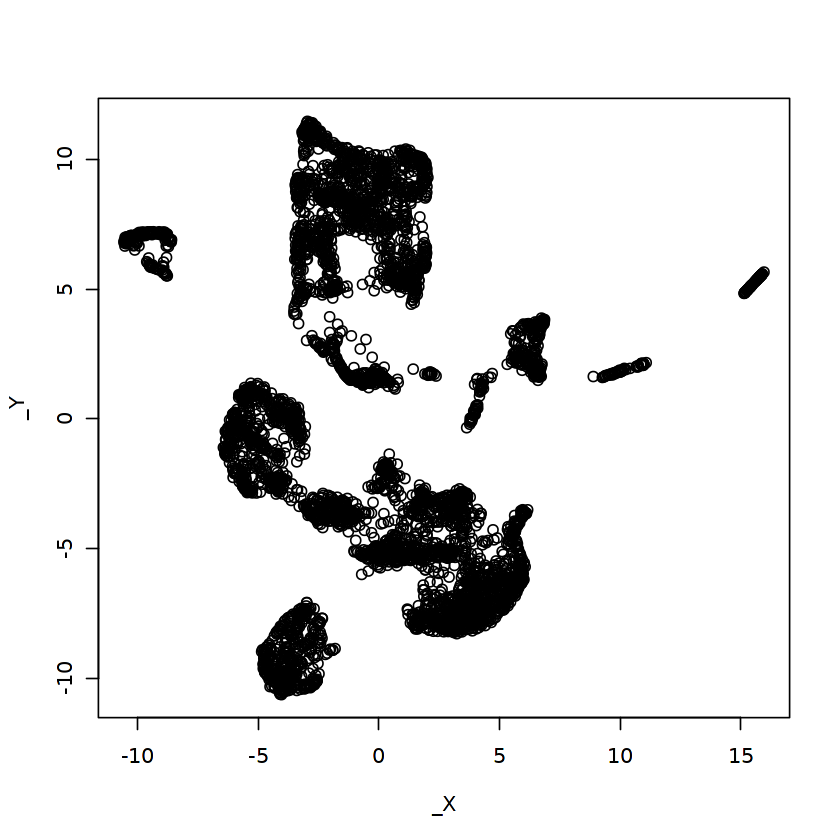

In [4]:
### Check whether data read properly:
length(regulons);  head(names(regulons))
regulonAUC
length(regulonAucThresholds)
plot(embeddings$`umap`)

## Genotype

In [6]:
selectedResolution <- "genotype" # select resolution

# Split the cells by cluster:
cellsPerGenotype <- split(rownames(genotype), genotype[,selectedResolution]) 
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]

# Calculate average expression:
regulonActivity_byGenotype <- sapply(cellsPerGenotype, function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
write.csv(regulonActivity_byGenotype, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonActivity_avg.csv")  
                                     
# Scale expression:
regulonActivity_byGenotype_Scaled <- t(scale(t(regulonActivity_byGenotype), center = T, scale=T))
write.csv(regulonActivity_byGenotype_Scaled, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonActivity_scaled.csv")   

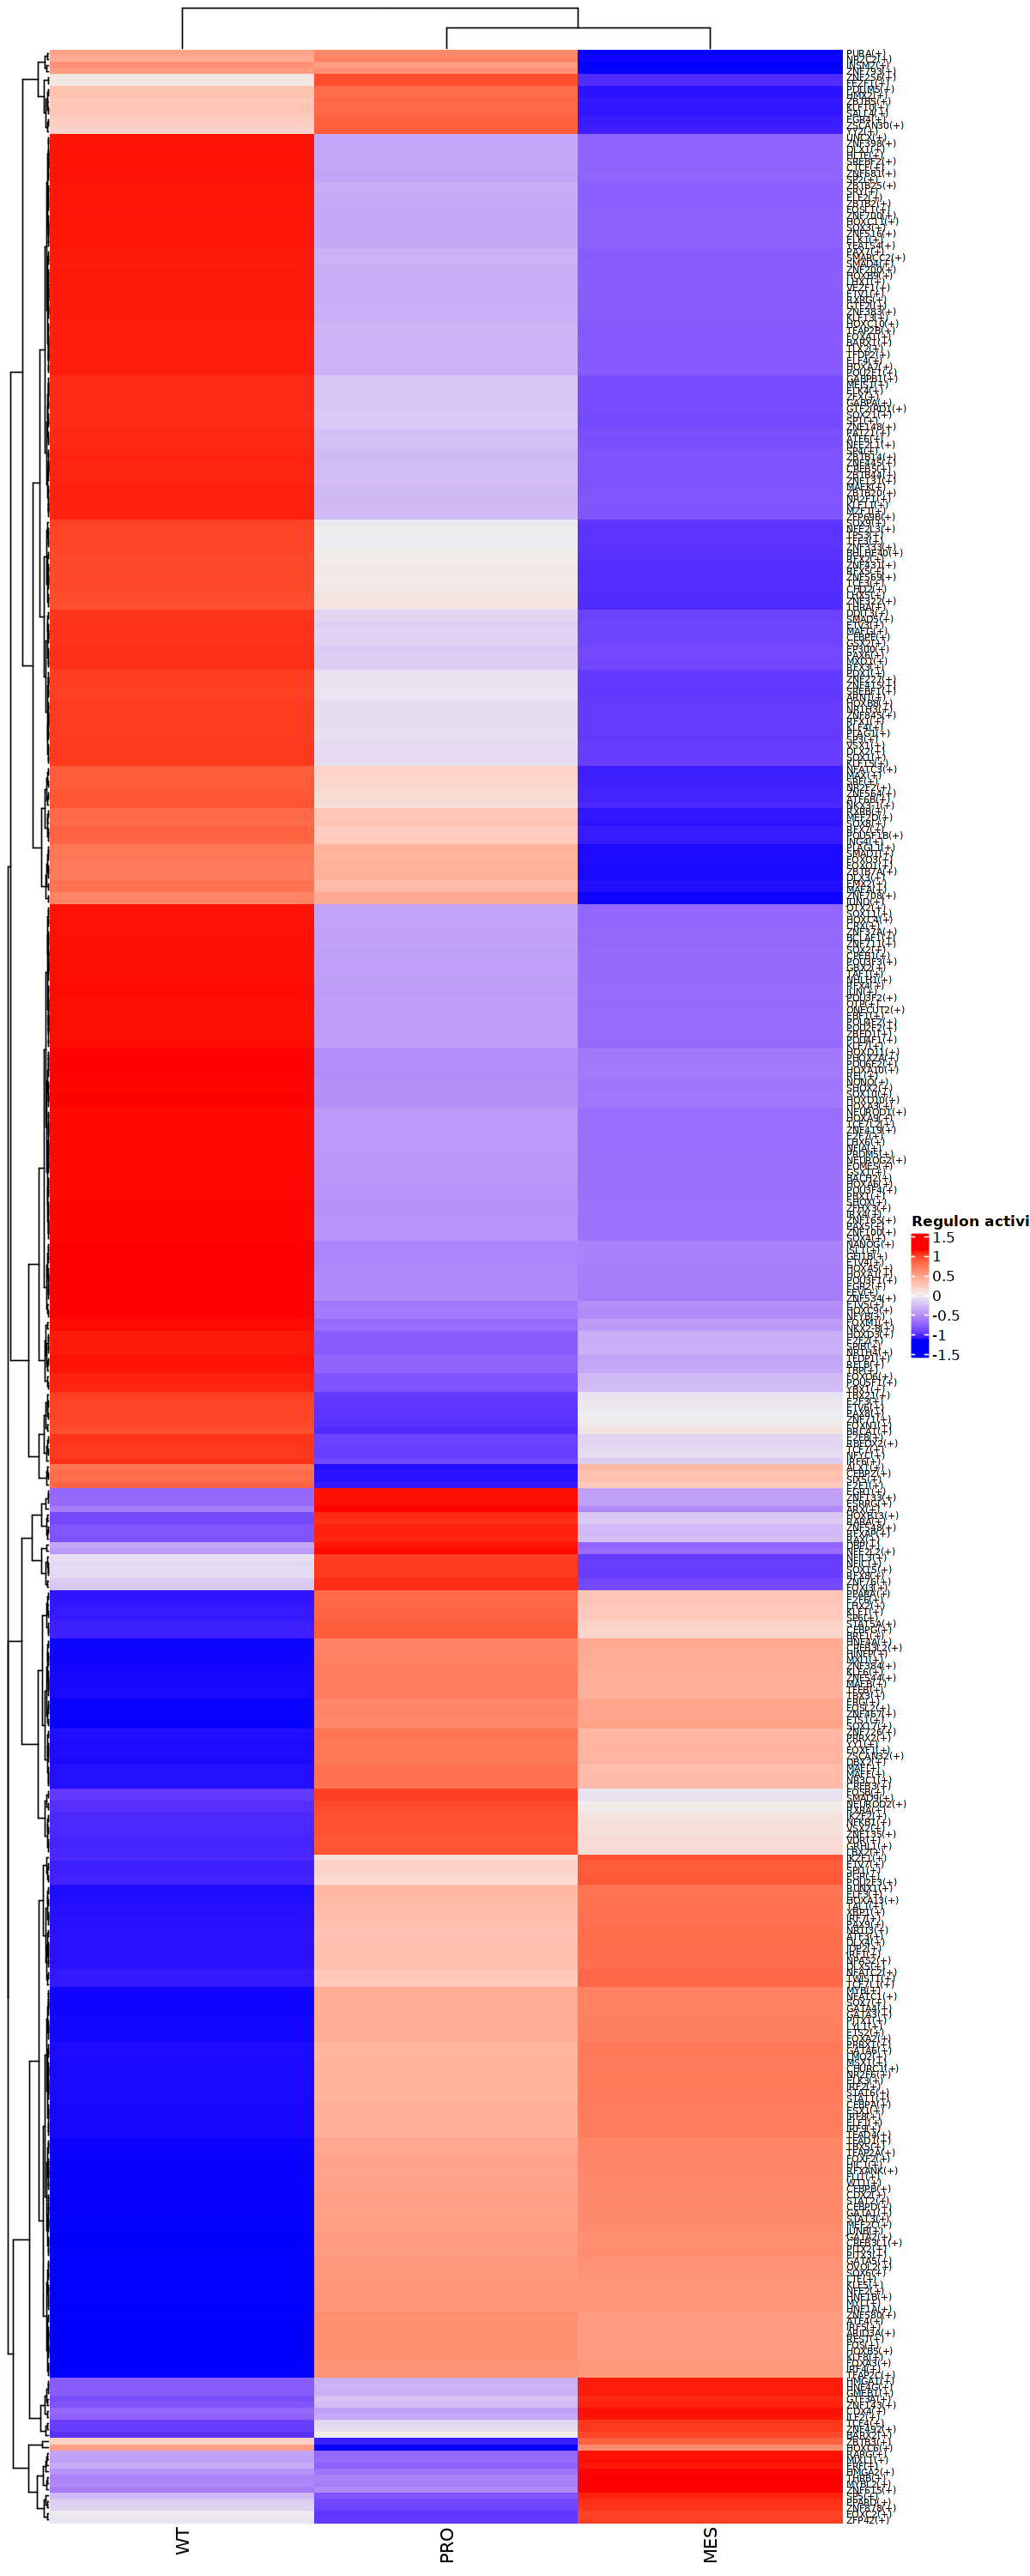

In [12]:
# plot:
options(repr.plot.width=10, repr.plot.height=25) # To set the figure size in Jupyter

hm <- draw(ComplexHeatmap::Heatmap(regulonActivity_byGenotype_Scaled, name="Regulon activity",
                       row_names_gp=grid::gpar(fontsize=6))) # row font size

regulonOrder <- rownames(regulonActivity_byGenotype_Scaled)[row_order(hm)] # to save the clustered regulons for later
write.csv(regulonOrder, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonOrder.csv")  

In [8]:
rss2 <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=genotype[colnames(regulonAUC), selectedResolution])
write.csv(rss2, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonSpecificityScore.csv") 

Loading required package: BiocParallel



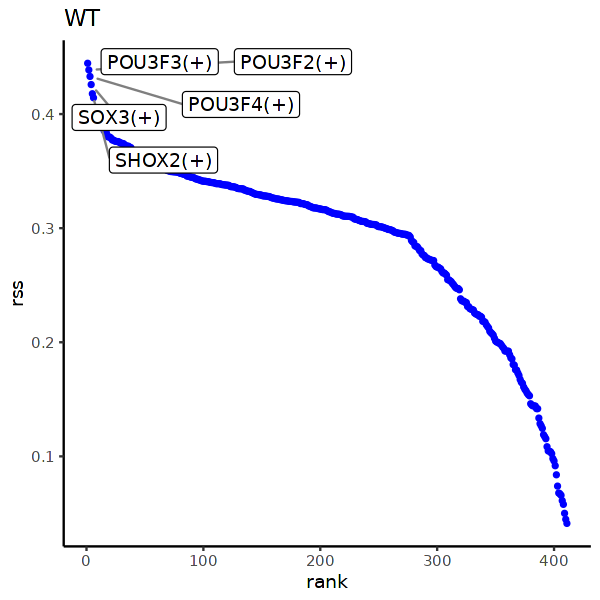

In [9]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss2, setName = "WT") # cluster ID

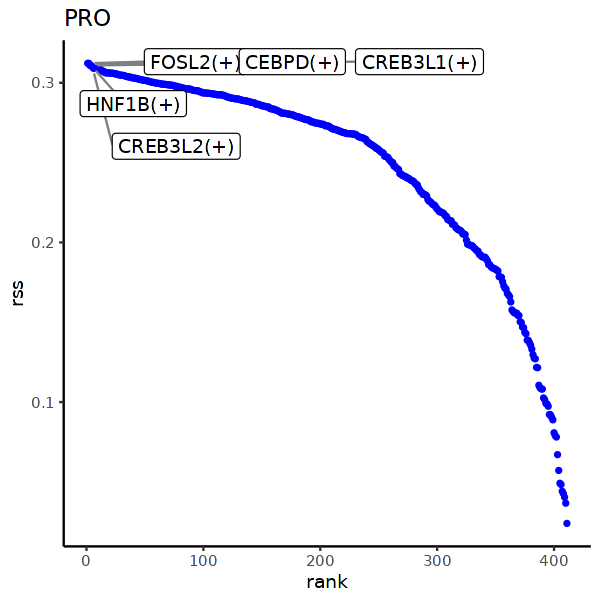

In [10]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss2, setName = "PRO") # cluster ID

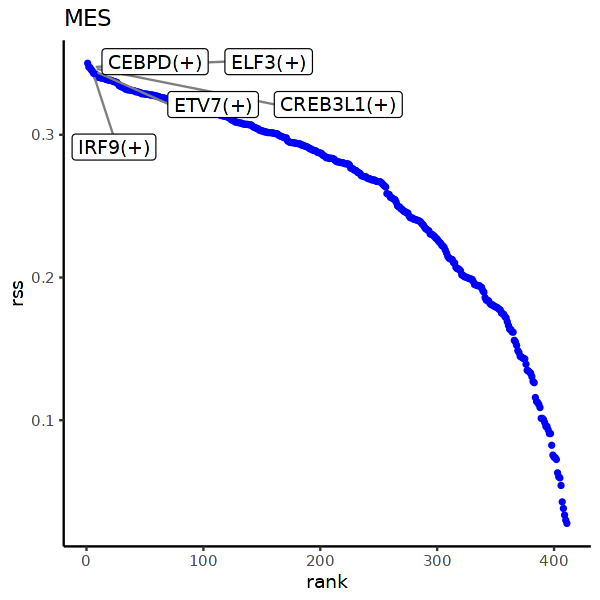

In [11]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss2, setName = "MES") # cluster ID